In [1]:
# Import the libraries
import tweepy
import configparser
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import requests
import os
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
# read configs
config = configparser.ConfigParser()
config.read('config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

api_key

'B6mzf9ArWlSiMb4KIwiPI5jMz'

In [3]:
#authentication
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

In [4]:
place_id = '6416b8512febefc9'
geocode = '54.00366, -2.547855, 380mi'

In [5]:
api.search_geo(query='united kingdom', granularity='country')[2]

Place(_api=<tweepy.api.API object at 0x000001B1BF841BB0>, id='6416b8512febefc9', name='United Kingdom', full_name='United Kingdom', country='United Kingdom', country_code='GB', url='https://api.twitter.com/1.1/geo/id/6416b8512febefc9.json', place_type='country', attributes={}, bounding_box=BoundingBox(_api=<tweepy.api.API object at 0x000001B1BF841BB0>, type='Polygon', coordinates=[[[-8.662663, 49.1626564], [-8.662663, 60.86165], [1.768926, 60.86165], [1.768926, 49.1626564], [-8.662663, 49.1626564]]]), centroid=[-1.9280961449649903, 54.3306728], contained_within=[])

In [ ]:
#user tweets
keywords = 'Morrisons -filter:retweets' #place:%s' % place_id
limit = 10000

tweets = tweepy.Cursor(api.search_tweets, lang='en', q=keywords, 
                       count=limit, 
                       #geocode = '51.509865, -0.118092, 250mi',
                       tweet_mode='extended').items(limit)
columns = ['Time', 'User','Location', 'Tweet', 'Favourites_count','retweet_count']
data = []
for tweet in tweets:
    data.append([tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.full_text, tweet.user.favourites_count,tweet.retweet_count])

df = pd.DataFrame(data, columns=columns)
df

Rate limit reached. Sleeping for: 610


In [105]:
df.to_csv('tweets.csv')

In [6]:
bearer_token='AAAAAAAAAAAAAAAAAAAAALrlfAEAAAAAO4fxHz7WtSSp4YoTSXIVjE94uTI%3Dz8qZV7q3iriCdmkpLOAM7YM0wdvX2Tdrf1g9kSQoI4azB234FD'

In [93]:
client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=api_key, 
                        consumer_secret=api_key_secret, 
                        access_token=access_token, 
                        access_token_secret=access_token_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)

hoax_tweets = []
query = 'aldi lang:en -is:retweet'

# Replace the limit=1000 with the maximum number of Tweets you want
for response in tweepy.Paginator(client.search_recent_tweets, query=query,
                              user_fields = ['username', 'public_metrics', 'description', 'location'],
                              tweet_fields = ['author_id','created_at','text','source', 'public_metrics','geo'],
                              expansions = ['geo.place_id', 'author_id'],
                              place_fields = ['country','country_code'],
                              max_results = 100,
                              ):
    hoax_tweets.append(response)
    
result = []
user_dict = {}
media_dict = {}


# Loop through each response object
for response in hoax_tweets:
    # Take all of the users, and put them into a dictionary of dictionaries with the info we want to keep
    for user in response.includes['users']:
        user_dict[user.id] = {'username': user.username, 
                              'followers': user.public_metrics['followers_count'],
                              'tweets': user.public_metrics['tweet_count'],
                              'description': user.description,
                              'location': user.location,
                              'verified': user.verified
                             }

    for tweet in response.data:
        # For each tweet, find the author's information
        author_info = user_dict[tweet.author_id]
        # Put all of the information we want to keep in a single dictionary for each tweet
        result.append({'author_id': tweet.author_id, 
                       'username': author_info['username'],
                       'author_followers': author_info['followers'],
                       'author_tweets': author_info['tweets'],
                       'author_description': author_info['description'],
                       'author_location': author_info['location'],
                       'author_verified':author_info['verified'],
                       'tweet_id': tweet.id,
                       'text': tweet.text,
                       'created_at': tweet.created_at,
                       'retweets': tweet.public_metrics['retweet_count'],
                       'replies': tweet.public_metrics['reply_count'],
                       'likes': tweet.public_metrics['like_count'],
                       'quote_count': tweet.public_metrics['quote_count'],
                       'in_reply_to_user_id':tweet.in_reply_to_user_id,
                       'conversation':tweet.referenced_tweets
                      })
df2 = pd.DataFrame(result)

AttributeError: 'Response' object has no attribute 'meta'

In [185]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

# Creating list to append tweet data to
attributes_container = []
loc = '54.00366, -2.547855, 500mi'

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('Morrisons since:2019-05-01 until:2019-08-01 lang:en geocode:"{}"'.format(loc)).get_items()):
    if i>10999:
        break
    attributes_container.append([tweet.user.username, tweet.date, tweet.likeCount, tweet.user.location, tweet.content,tweet.retweetCount])
    
# Creating a dataframe to load the list
tweets_df = pd.DataFrame(attributes_container, columns=["User", "Date Created", "Number of Likes", "Location", "Tweet", "retweet_count"])

In [186]:
tweets_df['Date Created']

0      2019-07-31 21:18:19+00:00
1      2019-07-31 21:15:43+00:00
2      2019-07-31 20:24:04+00:00
3      2019-07-31 19:55:39+00:00
4      2019-07-31 19:47:33+00:00
                  ...           
4488   2019-05-01 09:57:00+00:00
4489   2019-05-01 08:33:53+00:00
4490   2019-05-01 08:24:34+00:00
4491   2019-05-01 08:21:12+00:00
4492   2019-05-01 06:57:09+00:00
Name: Date Created, Length: 4493, dtype: datetime64[ns, UTC]

In [188]:
tweets_df.to_csv('mor 190501 190801.csv')

# Analysis

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
sid= SentimentIntensityAnalyzer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')
stop_words = stopwords.words('english')
custom_stopwords = ('RT', '#aldi','one','get','got','amp','im','ive','ill','aldi_ireland','aldi','aldiuk')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Aldi

In [110]:
df = pd.read_csv('aldi 180101 180701.csv')
print(df.shape)
df=df.iloc[:,1:]

(10673, 7)


In [4]:
df = pd.read_csv('aldi 180701 181231.csv')
print(df.shape)
df=df.iloc[:,1:]

(12775, 7)


In [118]:
df = pd.read_csv('aldi 190101 190701.csv')
print(df.shape)
df=df.iloc[:,1:]

(8505, 7)


In [248]:
df = pd.read_csv('aldi 181101 190201.csv')
print(df.shape)
df=df.iloc[:,1:]

(7075, 7)


In [69]:
df = pd.read_csv('aldi 19.csv')
print(df.shape)
df=df.iloc[:,1:]

(17158, 7)


In [4]:
df.head()

User               Date Created  Number of Likes  \
0         gemc200  2018-06-30 22:48:00+00:00                1   
1    ZoeAshbridge  2018-06-30 22:19:46+00:00                1   
2   ruth_pickford  2018-06-30 21:17:02+00:00                0   
3   robingill1984  2018-06-30 21:16:14+00:00                1   
4  Black_Crab_MCR  2018-06-30 21:15:27+00:00                1   

              Location                                              Tweet  \
0    Glasgow, Scotland  @AldiUK Your veggie sushi was delicious, as a ...   
1  Highlands, Scotland  #JOGLE 🏴󠁧󠁢󠁳󠁣󠁴󠁿🚴🏻‍♂️🚴🏻‍♀️🏴󠁧󠁢󠁥󠁮󠁧󠁿 Day 2 : \n\nTh...   
2  North West, England  @AldiUK @baberooo please shop at Aldi and save...   
3                  NaN  It was too hot to cook so a bottle of @AldiUK ...   
4                  NaN  @Out_About_Mummy @AldiUK Ah nevermind! Was a l...   

   retweet_count  
0              0  
1              1  
2              0  
3              0  
4              0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23448 entries, 0 to 23447
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User             23448 non-null  object
 1   Date Created     23448 non-null  object
 2   Number of Likes  23448 non-null  int64 
 3   Location         20236 non-null  object
 4   Tweet            23448 non-null  object
 5   retweet_count    23448 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [5]:
def preprocess_tweets(tweet, custom_stopwords):
    processed_tweet = tweet
    #processed_tweet.replace('[^\w\s]', '')
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in stop_words)
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in custom_stopwords)
    processed_tweet = " ".join(Word(word).lemmatize() for word in processed_tweet.split())
    return(processed_tweet)

In [6]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r'\@[^\s]+','',text)
    text = re.sub('@[^\s]+','',text)
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data


In [7]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def sentiment(label):
    if label>0:
        return "Positive"
    elif label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    


In [8]:
df['text'] = df['Tweet'].apply(lambda x: preprocess_tweets(x, custom_stopwords))
df.head()

User               Date Created  Number of Likes  \
0    FaerieDreamE  2018-12-30 23:32:18+00:00                0   
1   kellycrosbysw  2018-12-30 23:30:55+00:00                2   
2        jomccran  2018-12-30 22:49:02+00:00                0   
3  macmillan_ross  2018-12-30 22:21:31+00:00                1   
4         jeniaob  2018-12-30 22:17:04+00:00                2   

                  Location                                              Tweet  \
0  England, United Kingdom  @AldiUK Be more mindful of life around me and ...   
1                  Ireland  Super 6 @Aldi_Ireland  this week, great way to...   
2                Edinburgh                                    @AldiUK Working   
3                  Prenton  @OpenAirEnd @PaulRicci1 1500 of us with man fl...   
4  Kings Heath Birmingham   Thanks #aldi we paid a visit to your #maypole ...   

   retweet_count                                               text  
0              0  @AldiUK Be mindful life around effect react ot...  
1              1  Super 6 @Aldi_Ireland week, great way back tra...  
2              0                                    @AldiUK Working  
3              0  @OpenAirEnd @PaulRicci1 1500 u man flu end Ald...  
4              0  Thanks paid visit #maypole store today lovely ...

In [9]:
df['Date'] = pd.to_datetime(df['Date Created'])
df['Month'] = df['Date'].dt.month

text_df=df.drop(['User','Date Created','Number of Likes','Location','Tweet','retweet_count'], axis=1)

In [10]:
df.loc[:,'text'] = df['text'].apply(data_processing)
df = df.drop_duplicates('text')

df.loc[:,'text'] = df['text'].apply(lambda x: stemming(x))

df.head(10)

User               Date Created  Number of Likes  \
0     FaerieDreamE  2018-12-30 23:32:18+00:00                0   
1    kellycrosbysw  2018-12-30 23:30:55+00:00                2   
2         jomccran  2018-12-30 22:49:02+00:00                0   
3   macmillan_ross  2018-12-30 22:21:31+00:00                1   
4          jeniaob  2018-12-30 22:17:04+00:00                2   
5  factory_sausage  2018-12-30 22:04:43+00:00                5   
6      moonface_09  2018-12-30 22:01:14+00:00                0   
7       IzzyRutter  2018-12-30 21:15:59+00:00                1   
8        morgkaz48  2018-12-30 20:31:19+00:00                0   
9      NEFamilyFun  2018-12-30 20:07:34+00:00                0   

                  Location                                              Tweet  \
0  England, United Kingdom  @AldiUK Be more mindful of life around me and ...   
1                  Ireland  Super 6 @Aldi_Ireland  this week, great way to...   
2                Edinburgh                                    @AldiUK Working   
3                  Prenton  @OpenAirEnd @PaulRicci1 1500 of us with man fl...   
4  Kings Heath Birmingham   Thanks #aldi we paid a visit to your #maypole ...   
5          Northampton, UK  Jeez. I've eaten more fruit this week than I h...   
6          Nottinghamshire  Just been in #Aldi in Ireland and found a Kevi...   
7           Crewe, England  @BohoRaspberry @JodeF7 Home bargain and aldi o...   
8                   Home 🏠                 @Stephyish @AldiUK Safe journey 👍😊   
9       North East England  @nomipalony I used to be terrible at rememberi...   

   retweet_count                                               text  \
0              0        mindful life around effect react others xxx   
1              1  super 6 week great way back track slimmingworl...   
2              0                                            working   
3              0                   1500 u man flu end aldi attached   
4              0  thanks paid visit maypole store today lovely s...   
5              0  jeez ive eaten fruit week last year think with...   
6              0  aldi ireland found kevin katie family carrot y...   
7              0              home bargain often cheap plant rescue   
8              0                                       safe journey   
9              0  used terrible remembering remember im much bet...   

                       Date  Month  
0 2018-12-30 23:32:18+00:00     12  
1 2018-12-30 23:30:55+00:00     12  
2 2018-12-30 22:49:02+00:00     12  
3 2018-12-30 22:21:31+00:00     12  
4 2018-12-30 22:17:04+00:00     12  
5 2018-12-30 22:04:43+00:00     12  
6 2018-12-30 22:01:14+00:00     12  
7 2018-12-30 21:15:59+00:00     12  
8 2018-12-30 20:31:19+00:00     12  
9 2018-12-30 20:07:34+00:00     12

In [11]:
df['scores']=df['text'].apply(lambda text: sid.polarity_scores(text))
df['compound']=df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment'] = df['compound'].apply(sentiment)
df.head()

User               Date Created  Number of Likes  \
0    FaerieDreamE  2018-12-30 23:32:18+00:00                0   
1   kellycrosbysw  2018-12-30 23:30:55+00:00                2   
2        jomccran  2018-12-30 22:49:02+00:00                0   
3  macmillan_ross  2018-12-30 22:21:31+00:00                1   
4         jeniaob  2018-12-30 22:17:04+00:00                2   

                  Location                                              Tweet  \
0  England, United Kingdom  @AldiUK Be more mindful of life around me and ...   
1                  Ireland  Super 6 @Aldi_Ireland  this week, great way to...   
2                Edinburgh                                    @AldiUK Working   
3                  Prenton  @OpenAirEnd @PaulRicci1 1500 of us with man fl...   
4  Kings Heath Birmingham   Thanks #aldi we paid a visit to your #maypole ...   

   retweet_count                                               text  \
0              0        mindful life around effect react others xxx   
1              1  super 6 week great way back track slimmingworl...   
2              0                                            working   
3              0                   1500 u man flu end aldi attached   
4              0  thanks paid visit maypole store today lovely s...   

                       Date  Month  \
0 2018-12-30 23:32:18+00:00     12   
1 2018-12-30 23:30:55+00:00     12   
2 2018-12-30 22:49:02+00:00     12   
3 2018-12-30 22:21:31+00:00     12   
4 2018-12-30 22:17:04+00:00     12   

                                              scores  compound sentiment  
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   Neutral  
1  {'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'comp...    0.8402  Positive  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   Neutral  
3  {'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp...   -0.3818  Negative  
4  {'neg': 0.0, 'neu': 0.595, 'pos': 0.405, 'comp...    0.8979  Positive

text_df['polarity'] = text_df['text'].apply(polarity)
text_df.head(10)
#text_df['subjectivity'] = text_df['text'].apply(subjectivity)
#text_df.head(10)
text_df['sentiment'] = text_df['polarity'].apply(sentiment)
text_df.head()

In [12]:
df.sentiment.value_counts()

Positive    6197
Neutral     3776
Negative    1940
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

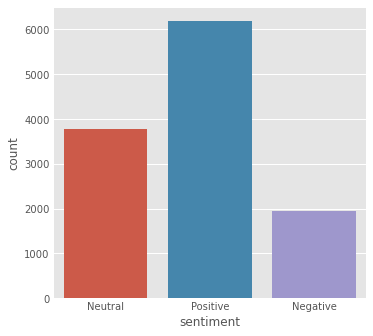

In [13]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = df)


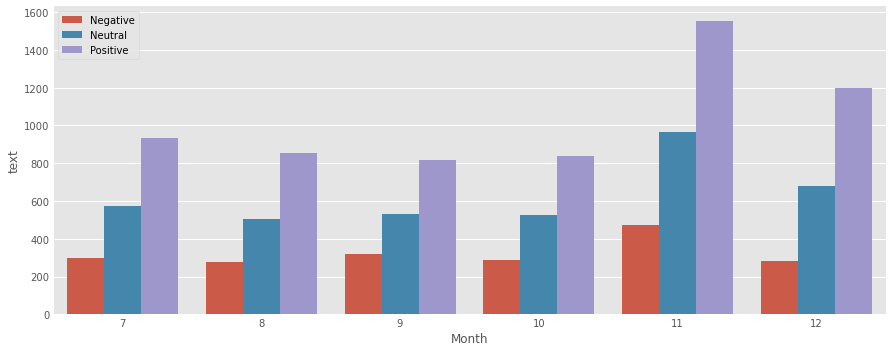

In [14]:
sentiment_month=pd.DataFrame(df.groupby(['Month','sentiment'])['text'].count())
#plt.figure(figsize=(20,5))
sns.catplot(kind='bar',x='Month',
            y='text',hue='sentiment', legend=False, 
            height=5, # make the plot 5 units high
            aspect=2.5,
            data=sentiment_month.reset_index())
plt.legend(loc='upper left')

In [15]:
df2=df.groupby(['Month','sentiment']).agg({'text':'count'})
df3 = df2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

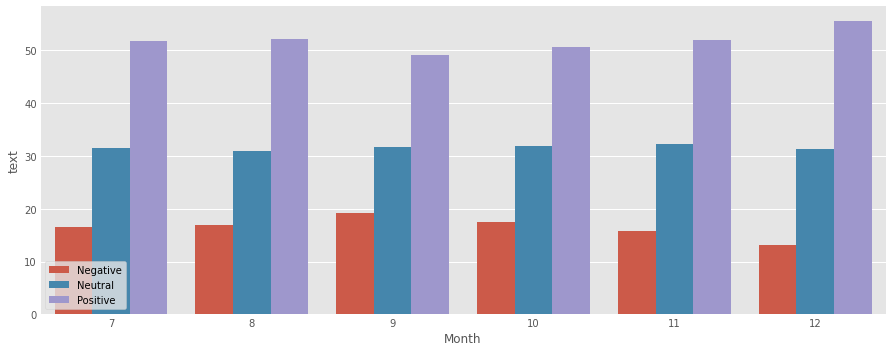

In [16]:
sns.catplot(kind='bar',x='Month',
            y='text',hue='sentiment', legend=False, 
            height=5, # make the plot 5 units high
            aspect=2.5,
            data=df3.reset_index())
plt.legend(loc='lower left')

Text(0.5, 1.0, 'Distribution of sentiments')

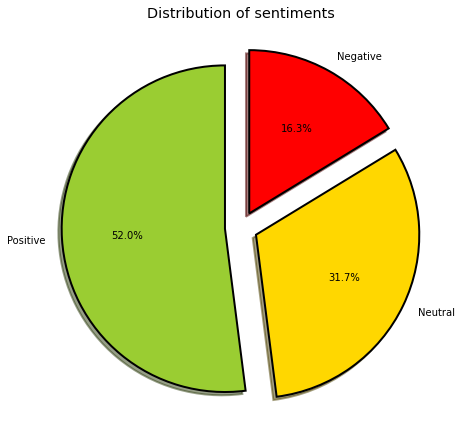

In [17]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [18]:
pos_tweets = df[df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['compound'], ascending= False)
pos_tweets.head(10)
pd.options.display.max_colwidth = 100

In [263]:
pos_tweets.text.head(10)

1859              love actually liked following happily retweeted thanks giving opportunity win great prize
4179                           wow lovely hope lucky thanks chance good luck everyone ive happily retweeted
6877                         would love win amazing prize love baking nice treat child especially christmas
2357                            liked following happily retweeted thanks giving opportunity win great prize
5389    im liking rtampf chance win lovely luxury christmas assortment friday id moon amp around sun amp...
6138    great night yesterday women business 2018 supporting excellent speakers lovely high tea excited ...
5543    win parents theyve high low life supporting throughout kind generous happy giving love without q...
2903    beyond amazing amp super impressed vegangluten free etc option youve offer ive go pescatarian iv...
4947    rtampf chance win ridiculous passion passionfruit id love winner award winning passionfruit gin ...
2400                        

In [19]:
#stop_words.append('aldi_ireland','aldi','aldiuk')
#for word in ['one','get','got','amp','im']:
my_stop_words=['would','shopping','shop','go','going','store','like','one','get','got','amp','im','ive','ill','aldi_ireland','aldi','aldiuk']


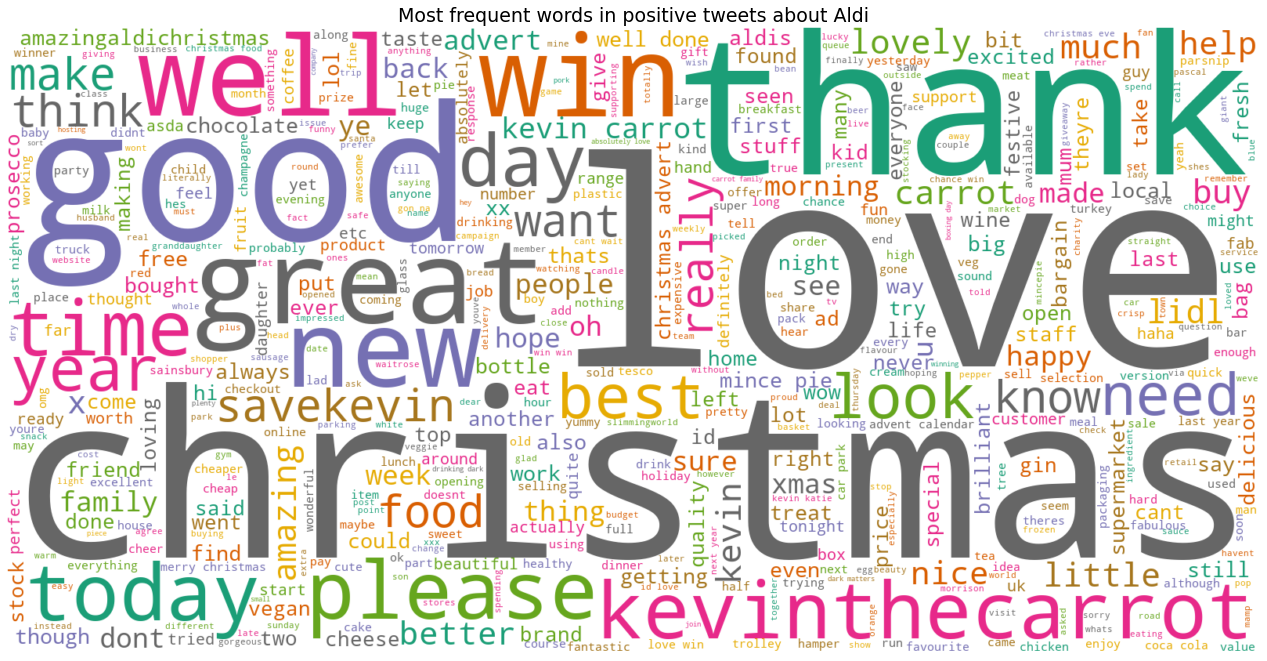

In [269]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets about Aldi', fontsize=19)
plt.show()

In [20]:
neg_tweets = df[df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['compound'], ascending= False)
neg_tweets.head(10)

User               Date Created  Number of Likes  \
9737   naomi_slocombe  2018-08-20 14:37:57+00:00                0   
3612      lyns_wall74  2018-11-18 15:22:40+00:00                0   
7680     mrbancroft79  2018-09-23 11:25:30+00:00                0   
6876     PaulCDunnEsq  2018-10-06 17:50:48+00:00                1   
1252   PaulGHernandez  2018-12-13 15:05:45+00:00                0   
6966   OliviaMulhearn  2018-10-05 16:18:20+00:00                0   
4660   BirminghamCats  2018-11-07 17:44:14+00:00                2   
6542     beccalrprice  2018-10-12 12:28:12+00:00                2   
9444      doughtagnan  2018-08-24 22:09:58+00:00                2   
10378  elliesmith1980  2018-08-08 16:46:56+00:00                3   

                         Location  \
9737                          NaN   
3612                   merseyside   
7680            Winsford, England   
6876                           UK   
1252               Manchester, UK   
6966           Liverpool, England   
4660   Birmingham, United Kingdom   
6542                 norfolk, uk    
9444          Halesworth, England   
10378    Bradford, West Yorkshire   

                                                                                                     Tweet  \
9737   If people want to moan about a item going up in Aldi by 4 pence! Go and shop in Tesco!At least  ...   
3612             @AldiUK Oooooh I’m so excited 😆 my son and myself can’t wait 😊 thanks for letting me know   
7680                                  @Julie_83 @AldiUK It’s getting worse. The Northwich was really nice.   
6876   I really like Aldi’s products and I can do a cheaper shop. What I find off putting is the way it...   
1252   My poor Mum went and got a tree from @AldiUK in Beighton and after only a few days it shed half ...   
6966               Aldi healthy glow! Is it really a dupe? https://t.co/WfWLOHghEW https://t.co/azS5dOUFQU   
4660   Dear @AldiUK what are you putting in your catnip toys? The cats of Birmingham are going absolute...   
6542   Not that what Aldi is doing isn’t great, but Tesco give away all their surplus food to homeless ...   
9444   @dnkrbywine if you pop to @AldiUK and cannot get the Orange wine try this German red, great for ...   
10378                                  @AldiUK This is Albus, just chilling out. 😎 https://t.co/kcYYw6YXN2   

       retweet_count  \
9737               0   
3612               0   
7680               0   
6876               0   
1252               0   
6966               0   
4660               0   
6542               0   
9444               0   
10378              0   

                                                                                                      text  \
9737   people want moan item going aldi 4 pence go shop tescoat least wont listen moaning customerproblems   
3612                                                   oooooh im excited son cant wait thanks letting know   
7680                                                                   getting worse northwich really nice   
6876     really like aldis product cheaper shop find putting way slung checkout scanned ill never big shop   
1252   poor mum went tree beighton day shed half needle turned lovely shade poo brown didnt even chance...   
6966                                                                         aldi healthy glow really dupe   
4660                  dear putting catnip toys cat birmingham going absolutely crazy especially banana one   
6542   aldi isnt great tesco give away surplus food homeless charities churches school etc every single...   
9444   pop orange wine try german red great blind tasting doubt anyone last year vintage back big old w...   
10378                                                                                       albus chilling   

                           Date  Month  \
9737  2018-08-20 14:37:57+00:00      8   
3612  2018-11-18 15:22:40+00:00     11   
7680  2018-09-23 11:25:30+00:00     

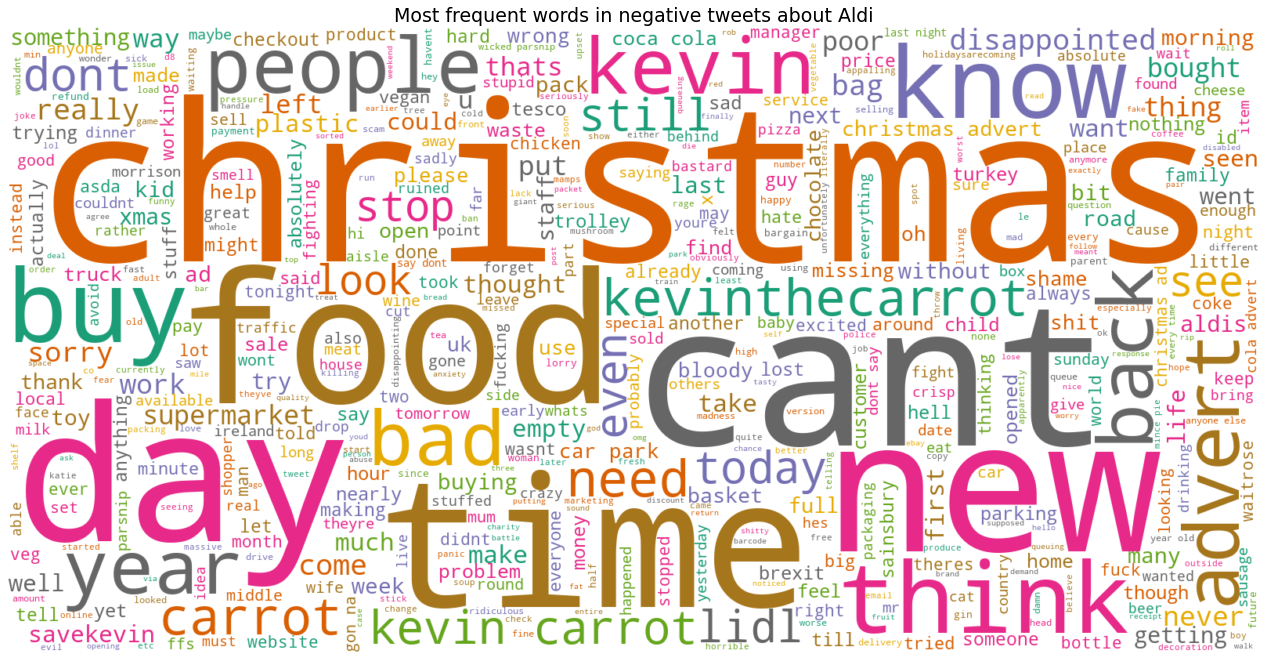

In [272]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets about Aldi', fontsize=19)
plt.show()

In [22]:
for i in range(10):
    print(i+1,'.',neg_tweets['text'].iloc[i],"\n")

1 . people want moan item going aldi 4 pence go shop tescoat least wont listen moaning customerproblems 

2 . oooooh im excited son cant wait thanks letting know 

3 . getting worse northwich really nice 

4 . really like aldis product cheaper shop find putting way slung checkout scanned ill never big shop 

5 . poor mum went tree beighton day shed half needle turned lovely shade poo brown didnt even chance put decoration 

6 . aldi healthy glow really dupe 

7 . dear putting catnip toys cat birmingham going absolutely crazy especially banana one 

8 . aldi isnt great tesco give away surplus food homeless charities churches school etc every single day christmas 

9 . pop orange wine try german red great blind tasting doubt anyone last year vintage back big old wine 14 

10 . albus chilling 



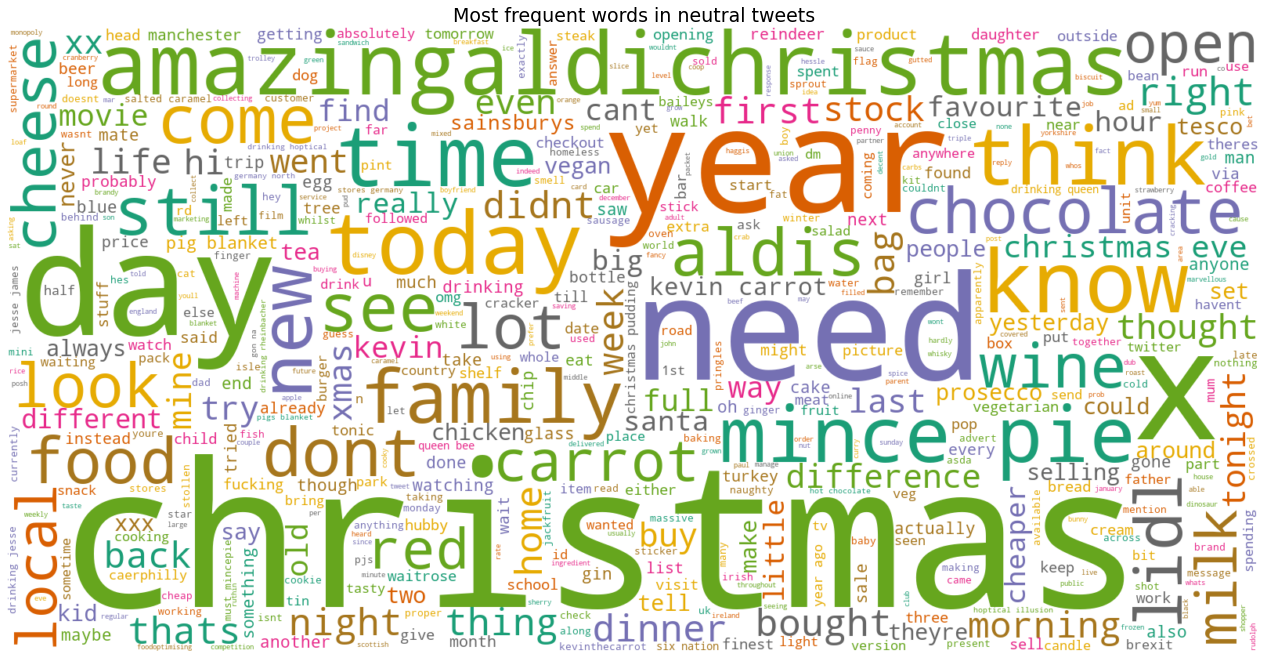

In [714]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['compound'], ascending= False)
neutral_tweets.head()
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

## Morrisons

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = stopwords.words('english')
custom_stopwords = ('RT', '#morrisons','one','get','got','amp','im','ive','ill')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [130]:
df = pd.read_csv('mor 180101 180701.csv')
print(df.shape)
df=df.iloc[:,1:]

(6623, 7)


In [131]:
df = pd.read_csv('mor 180701 190101.csv')
print(df.shape)
df=df.iloc[:,1:]

(6215, 7)


In [619]:
df = pd.read_csv('mor 190101 190701.csv')
print(df.shape)
df=df.iloc[:,1:]

(8479, 7)


In [623]:
df = pd.read_csv('mor 190701 200101.csv')
print(df.shape)
df=df.iloc[:,1:]

(9276, 7)


In [160]:
df = pd.read_csv('mor 19.csv')
print(df.shape)
df=df.iloc[:,1:]

(11220, 7)


In [9]:
df = pd.read_csv('mor 190501 190801.csv')
print(df.shape)
df=df.iloc[:,1:]

(2860, 7)


In [34]:
df = pd.read_csv('mor 190901 191201.csv')
print(df.shape)
df=df.iloc[:,1:]

(2909, 7)


In [526]:
df['Tweet'] = df['Tweet'].astype("string")

In [33]:
df=df[df['Tweet'].str.contains(rf'morrisons',case=False,regex=True)]
df.info()
df.to_csv('mor 190901 191201.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2909 entries, 1 to 4355
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User             2909 non-null   object
 1   Date Created     2909 non-null   object
 2   Number of Likes  2909 non-null   int64 
 3   Location         2600 non-null   object
 4   Tweet            2909 non-null   object
 5   retweet_count    2909 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 159.1+ KB


In [35]:
df['text'] = df['Tweet'].apply(lambda x: preprocess_tweets(x, custom_stopwords))
df.shape

(2909, 7)

In [36]:
df['Date'] = pd.to_datetime(df['Date Created'])
df['Month'] = df['Date'].dt.month

text_df=df.drop(['User','Date Created','Number of Likes','Location','Tweet','retweet_count'], axis=1)

In [37]:
df.loc[:,'text'] = df['text'].apply(data_processing)
df = df.drop_duplicates('text')

df.loc[:,'text'] = df['text'].apply(lambda x: stemming(x))

df.head(10)

User               Date Created  Number of Likes  \
0      Beleza_Rach  2019-11-30 21:19:27+00:00                1   
1    eliasgraham94  2019-11-30 20:57:24+00:00                0   
2     RCirishdance  2019-11-30 20:28:42+00:00                1   
3   TheRamblingElf  2019-11-30 20:18:17+00:00                1   
4    kezwilliams13  2019-11-30 20:04:21+00:00                0   
6    highlandsigar  2019-11-30 19:50:30+00:00                1   
7    eliasgraham94  2019-11-30 18:44:37+00:00                0   
9      MattWellock  2019-11-30 15:55:44+00:00                4   
10       spriggy45  2019-11-30 15:46:01+00:00                0   
11       spriggy45  2019-11-30 15:45:42+00:00                0   

                       Location  \
0   Edinburgh, Bonnie Scotland    
1          Aberdream, Scotland    
2                            UK   
3           Birmingham, England   
4             Redditch.England.   
6                           NaN   
7          Aberdream, Scotland    
9                   Manchester    
10          There's only 1 Boss   
11          There's only 1 Boss   

                                                Tweet  retweet_count  \
0   Couldn't face the IKEA crowds so nipped into @...              0   
1   @telstar9999 @Im_Cheaper_ @Morrisons Okay tony...              0   
2   Some video snippets from Norman's 100th bday c...              0   
3   Went to Morrisons today and was faced with a b...              0   
4   I'm at @Morrisons Redditch in Redditch, Worces...              0   
6   .@Tesco, @asda, @IcelandFoods, @Morrisons, @Sa...              0   
7                   @Morrisons I have done. Thank you              0   
9   On offer in Morrisons @Bigroey 👍🏼 https://t.co...              0   
10  I'm at Morrisons Sheffield - Hillsborough Petr...              0   
11  I'm at @Morrisons Sheffield - Hillsborough in ...              0   

                                                 text  \
0   couldnt face ikea crowd nipped picked 15 tree ...   
1                           okay tony blair calm doon   
2   video snippet normans 100th bday celebration t...   
3   went morrisons today faced bleak choice regula...   
4                 im redditch redditch worcestershire   
6   get banned beeharming pesticide shopping troll...   
7                                          done thank   
9                                     offer morrisons   
10  im morrisons sheffield hillsborough petrol sta...   
11  im sheffield hillsborough sheffield south york...   

                        Date  Month  
0  2019-11-30 21:19:27+00:00     11  
1  2019-11-30 20:57:24+00:00     11  
2  2019-11-30 20:28:42+00:00     11  
3  2019-11-30 20:18:17+00:00     11  
4  2019-11-30 20:04:21+00:00     11  
6  2019-11-30 19:50:30+00:00     11  
7  2019-11-30 18:44:37+00:00     11  
9  2019-11-30 15:55:44+00:00     11  
10 2019-11-30 15:46:01+00:00     11  
11 2019-11-30 15:45:42+00:00     11

In [38]:
df['scores']=df['text'].apply(lambda text: sid.polarity_scores(text))
df['compound']=df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment'] = df['compound'].apply(sentiment)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2825 entries, 0 to 2908
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   User             2825 non-null   object             
 1   Date Created     2825 non-null   object             
 2   Number of Likes  2825 non-null   int64              
 3   Location         2521 non-null   object             
 4   Tweet            2825 non-null   object             
 5   retweet_count    2825 non-null   int64              
 6   text             2825 non-null   object             
 7   Date             2825 non-null   datetime64[ns, UTC]
 8   Month            2825 non-null   int64              
 9   scores           2825 non-null   object             
 10  compound         2825 non-null   float64            
 11  sentiment        2825 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(7)
memory usage: 286

In [39]:
df.sentiment.value_counts()

Positive    1360
Neutral      752
Negative     713
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

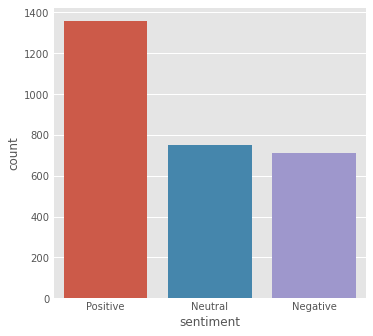

In [40]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = df)


In [41]:
df2=df.groupby(['Month','sentiment']).agg({'text':'count'})
df3 = df2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

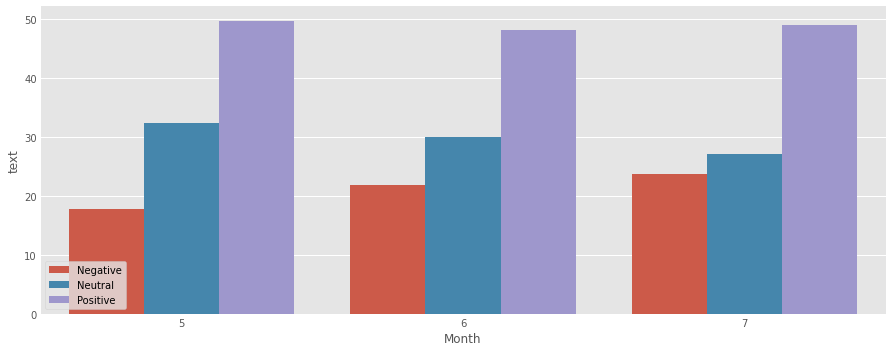

In [21]:
sns.catplot(kind='bar',x='Month',
            y='text',hue='sentiment', legend=False, 
            height=5, # make the plot 5 units high
            aspect=2.5,
            data=df3.reset_index())
plt.legend(loc='lower left')

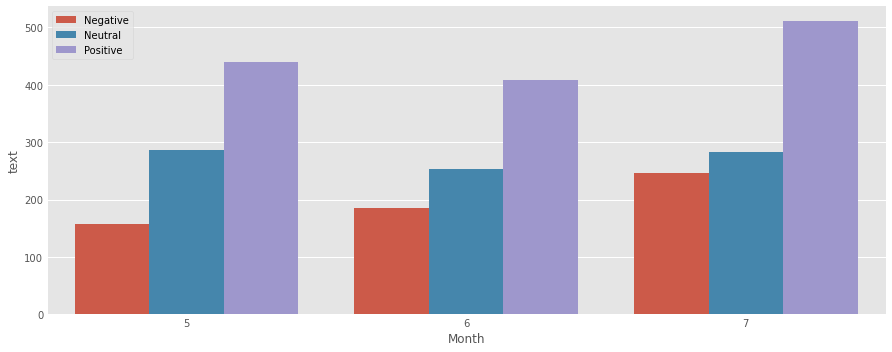

In [22]:
sentiment_month=pd.DataFrame(df.groupby(['Month','sentiment'])['text'].count())
#plt.figure(figsize=(20,5))
sns.catplot(kind='bar',x='Month',
            y='text',hue='sentiment', legend=False, 
            height=5, # make the plot 5 units high
            aspect=2.5,
            data=sentiment_month.reset_index())
plt.legend(loc='upper left')

Text(0.5, 1.0, 'Distribution of sentiments')

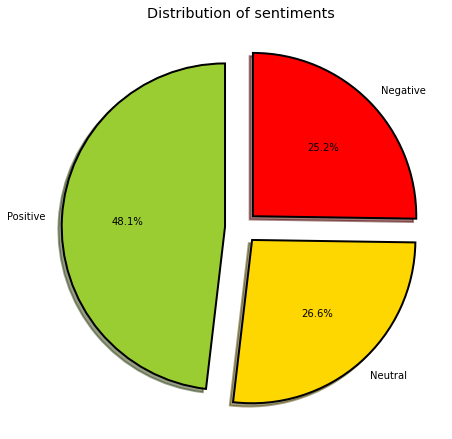

In [42]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [24]:
#stop_words.append('aldi_ireland','aldi','aldiuk')
#for word in ['one','get','got','amp','im']:
my_stop_words=['would','ive','going','go','like','store','shop','shopping','morrison','morrisons','one','get','got','amp','im','ill']


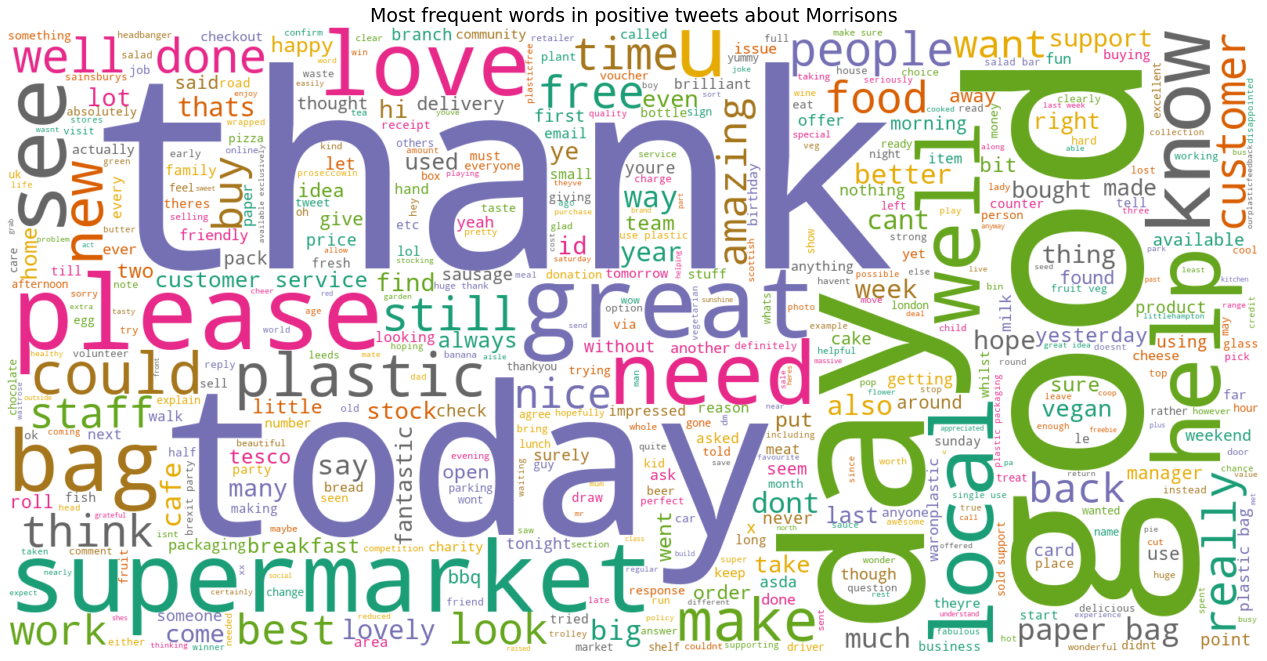

In [25]:
pos_tweets = df[df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['compound'], ascending= False)
pos_tweets.head()
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets about Morrisons', fontsize=19)
plt.show()

In [26]:
neg_tweets = df[df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['compound'], ascending= False)

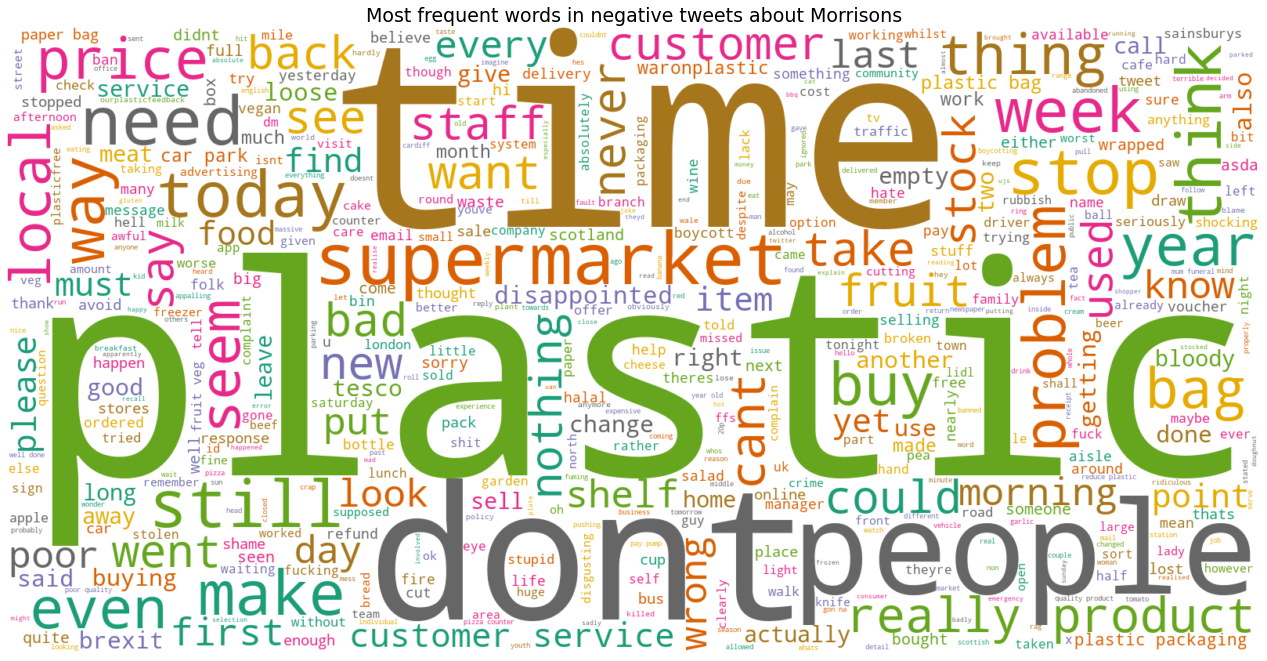

In [27]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets about Morrisons', fontsize=19)
plt.show()

In [28]:
for i in range(10):
    print(i+1,'.',neg_tweets['text'].iloc[i],"\n")


1 . would really appreciate reply find unacceptable 

2 . im beginning realise ive online shopping year never shopped store must clear voucher fraudulently used yet dont care 

3 . quite distressing watch clearly enough done supermarket consumer rely ball court reduce plastic waronplastic 

4 . hi nope replying people hoping acceptable response shortly 

5 . absolutely ridiculous need correct labelling amp customer service wouldnt serve bottle grenadine id bottle clearly stated front non alcoholic 

6 . else ordered 500g frozen melon ball selection latest shop chilling decadently mwahahaha moi absolute puppy private folks 

7 . make pizza decided get stood 5mins waiting told pizza short staffed went late stopped clean next time ill go straight 

8 . going years im sure someones house alarm police would involved 

9 . embarrassing thing scots like seem think plastering ujs scottish produce sensible get knee 

10 . looks like emergency appeal working donation point bursting 



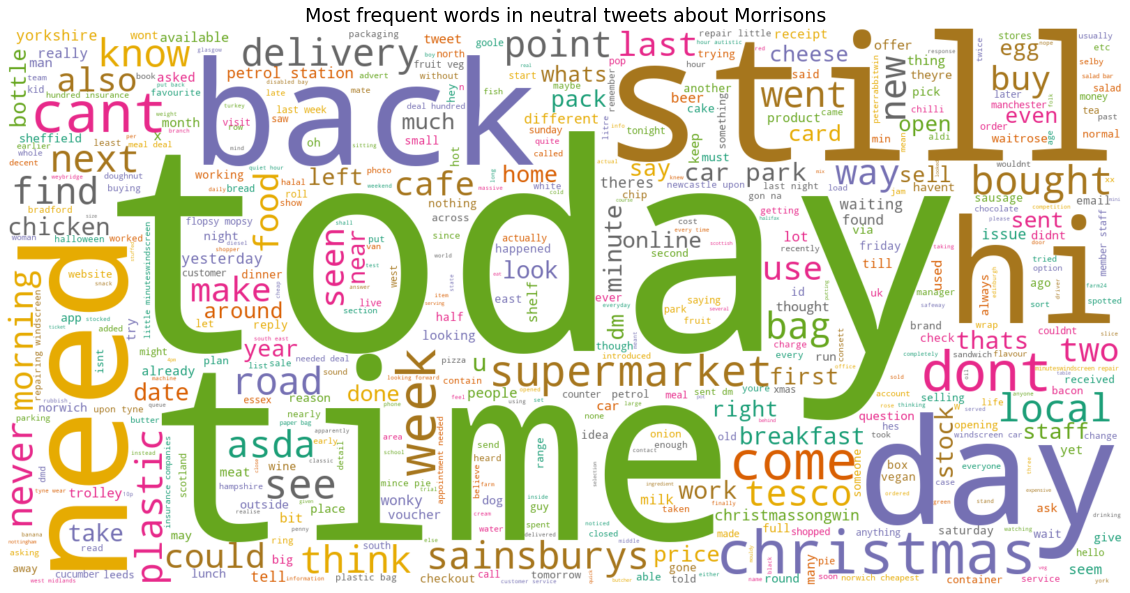

In [147]:
neutral_tweets = df[df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['compound'], ascending= False)
neutral_tweets.head()
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets about Morrisons', fontsize=19)
plt.show()